In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy

In [27]:
### Data managment
## input
df = pd.read_csv("data/train.csv")

## grouping into int categories
df["Sex"] = df["Sex"].replace({"male":0, "female":1})
df["Embarked"] = df["Embarked"].replace({'C':0, 'S':1, 'Q':2})
df["Cabin"] = df["Cabin"].apply(lambda x: 0 if x is np.nan else 1)

## handling names
title_dict = {"Mr.":1, "Mrs.":2, "Mme.":2, "Miss.":3, "Mlle.":3, "Master.":4, "Dr.":5, "Rev.": 6}

def name_lookup(name_str):
    for word in name_str.split():
        if word in title_dict.keys():
            return title_dict[word]
    return 0

df["Name"] = df["Name"].apply(name_lookup)

## handling nans
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode().iloc[0])

## creating input and output dataframes
yf = df["Survived"]
xf = df.drop(columns=["PassengerId", "Survived", "Ticket"])

## normalizing
features = ["Age", "Fare"]
xf[features] = (xf[features] - xf[features].mean()) / xf[features].std()
print(xf.head())

   Pclass  Name  Sex       Age  SibSp  Parch      Fare  Cabin  Embarked
0       3     1    0 -0.565419      1      0 -0.502163      0       1.0
1       1     2    1  0.663488      1      0  0.786404      1       0.0
2       3     3    1 -0.258192      0      0 -0.488580      0       1.0
3       1     2    1  0.433068      1      0  0.420494      1       1.0
4       3     1    0  0.433068      0      0 -0.486064      0       1.0


In [28]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

class FeedForwardNn:
    '''
    simples feed forward neural network. output has to be binary
    (can be generalized to a multiclass classifier though)
    '''
    def __init__(self):
        self.activation = sigmoid
        self.activation_derivative = sigmoid_derivative
        
    def initialize(self, x, y, hiden_shape):
        # input; np-like matrix; 1st index -- training example; 2nd index -- feature
        self.x = x
        # theoretical output; np-like vector; index -- training example
        self.y = y.reshape((y.size, 1))
        # list of sizes of all the layers (input, hidden, and output) has depth+2 elements
        self.shape = [self.x.shape[1]] + list(hiden_shape) + [self.y.shape[1]]
        self.depth = len(hiden_shape) # depth of the hidden layers
        # list of weights; has depth+1 elements
        self.weights = [np.random.rand(self.shape[l]+1, self.shape[l+1]) for l in range(self.depth+1)]
        
    def train(self, n_iter=100, reg=0, learning_rate=0.05):
        # list of h values; has depth+2 elements
        # the 1st feature is the constant feature which is never updated
        self.h_arr = [np.ones((self.y.size, self.shape[l]+1)) for l in range(self.depth+2)]
        self.h_arr[0][:,1:] = self.x
        # training
        for i in range(n_iter):
            self.forward_propagate()
            self.back_propagate(reg, learning_rate)
        
    def forward_propagate(self):
        for l in range(self.depth+1):
            self.h_arr[l+1][:,1:] = self.activation(self.h_arr[l] @ self.weights[l])
        
    def back_propagate(self, reg, learning_rate):
        # error at the output layer
        delta_1 = self.h_arr[-1][:,1:] - self.y
        # propagation of the errors depper to the hidden layers
        for l in range(self.depth+1):
            delta_2 = (delta_1 @ self.weights[-l-1].T) * self.activation_derivative(self.h_arr[-l-2])
            self.weights[-l-1] -= (self.h_arr[-l-2].T @ delta_1 / self.y.size +
                                   reg * self.weights[-l-1]) * learning_rate
            delta_1 = delta_2[:,1:]

    def evaluate(self, x, y):
        # reinitialize all the h vectors
        self.h_arr = [np.ones((y.size, self.shape[l]+1)) for l in range(self.depth+2)]
        self.h_arr[0][:,1:] = x
        self.forward_propagate()
        accuracy = (self.h_arr[-1][:,1:] < 0.5) ^ y.reshape((y.size, 1))
        return accuracy.sum() / accuracy.size

In [29]:
frac_train = 0.75
m, n = xf.shape
m1_arr = np.arange(5, m, 25)
score_train_arr, score_test_arr = [], []

for m1 in m1_arr:
    print("\r{0} out of {1}".format(m1, m), end='\r')
    # randomly choosing samples
    row_sampler = np.random.choice(m, m1, replace=False)
    ynp_m1 = yf.loc[row_sampler].to_numpy()
    xnp_m1 = xf.loc[row_sampler, :].to_numpy()
    # splitting into train and test
    m1_train = int(m1 * frac_train)
    ynp_m1_train = ynp_m1[:m1_train]
    xnp_m1_train = xnp_m1[:m1_train, :]
    ynp_m1_test = ynp_m1[m1_train:m1]
    xnp_m1_test = xnp_m1[m1_train:m1, :]
    # training
    ffnn = FeedForwardNn()
    ffnn.initialize(xnp_m1_train, ynp_m1_train, [5])
    ffnn.train(n_iter=2000, reg=0.01, learning_rate=0.2)
    score_train_arr.append(ffnn.evaluate(xnp_m1_train, ynp_m1_train))
    score_test_arr.append(ffnn.evaluate(xnp_m1_test, ynp_m1_test))

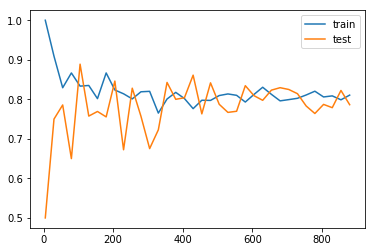

0.7863636363636364


In [7]:
fig, fax = plt.subplots()
fax.plot(m1_arr, score_train_arr, label="train")
fax.plot(m1_arr, score_test_arr, label="test")
plt.legend()
plt.show()
print(ffnn.evaluate(xnp_m1_test, ynp_m1_test))